In [1]:
import numpy as np
import copy
import pandas as pd
from gym_ur.game_of_ur2 import GoUrEnv
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
import dill
import os.path
plt.style.use('ggplot')

In [2]:
def eGreedyActionSelection(env, q_curr, eps, possible_actions, movable_piece_board_pos):
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        env: Environment
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        The selected action.
    '''
    if np.random.rand() < (1 - eps):
        best_val = np.max(q_curr)
        b_actions=np.arange(q_curr.size, dtype=int)[q_curr==best_val]
        best_action = np.random.choice(b_actions)
        if best_action in movable_piece_board_pos.keys():
            return movable_piece_board_pos[best_action]
        
    return np.random.choice(possible_actions)

In [3]:
# create environment
env = GoUrEnv(4)

In [4]:
def updateMCValues(Q_func, policy, episode_transitions, gamma, alpha):
    '''
    Updates the Q-function according to the given episode transitions.
    
    Args:
        Q_func: A dictonary mapping state -> action values.
        episode_transitions: A list of (state, action, reward) tuples describing the episode.
        gamma: The discount factor.
        alpha: The stepsize.
        
    Returns:
        The updated Q-function.
    '''
    G = 0
    episode_transitions = episode_transitions[::-1]
    for state, action, reward in episode_transitions:
        G = reward + (gamma * G)
        Q_func[state][action] += (alpha * (G - Q_func[state][action])) 
#         policy[state] = np.argmax(Q_func[state][action])
#         value_func[state] = Q_func[state][policy[state]]
    return Q_func, policy

In [5]:
def train_mc_agent(env, num_episodes, q1, ep1, ep2, eps=0.1, gamma=1.0, alpha=0.1, logging=False):
    player1 = 0
    player2 = 1
    init_q_value = 0.0
    policy = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
    episode_value_func = []
    
    # check for pickles
    if q1 == None:
        Q_func_1 = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
    else:
        Q_func_1 = q1

    
    episode_rewards_p1 = ep1
    episode_rewards_p2 = ep2
    time_to_win = []
    for curr_episode in range(num_episodes):
#         value_func = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
        episode_transitions = list()
        episode_transitions_p2 = list()
        dice_up = env.roll()
        state = env.reset(dice_up)
        is_done = False
        t = 0
        if logging:
            print(curr_episode)
            
        while True:
            # player 1 move
            t += 1
            
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player1, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q_func_1[state], eps, possible_actions, movable_piece_board_pos)
                new_state, reward_p1, done, _ = env.step(action, dice_up)
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                episode_transitions.append((state, action['board_pos'], reward_p1))
                state = copy.deepcopy(new_state)
                
                if done:
                    break
           
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player2, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q_func_1[state], eps, possible_actions, movable_piece_board_pos)
                new_state, reward_p2, done, _ = env.step(action, dice_up)
                episode_transitions.append((state, action['board_pos'], reward_p2))
                state = copy.deepcopy(new_state)

                if done:
                    break
            
            if logging:
                print(state, reward, done)
        
            dice_up = env.roll() # player 1 roll
            
        episode_rewards_p1[-1] =+ reward_p1
        episode_rewards_p1.append(0.0)
        
        episode_rewards_p2[-1] =+ reward_p2
        episode_rewards_p2.append(0.0)
        time_to_win.append(t)
        
        # Update the Q functions
        Q_func_1, policy = updateMCValues(Q_func_1, policy, episode_transitions, gamma, alpha)
#         Q_func_1, policy = updateMCValues(Q_func_1, policy, episode_transitions_p2, gamma, alpha)
#         total = 0 
#         for key, value in value_func.items():
#             total += value
#         episode_value_func.append(total)
    
    return Q_func_1, policy, episode_rewards_p1, episode_rewards_p2, time_to_win

In [ ]:
episode_rwds_p1 = []
episode_rwds_p2 = []
total_episodes = 50000
q1, q2, ep1, ep2 = None, None, [0.0], [0.0]

# train agent
q_func_1, policy, episode_rewards_p1, episode_rewards_p2, time_to_win, episode_value_func = train_mc_agent(env, total_episodes,
                                                                            q1, ep1, 
                                                                            ep2, eps=0.2)
        
# append rewards for each run
episode_rwds_p1.append(episode_rewards_p1)
episode_rwds_p2.append(episode_rewards_p2)

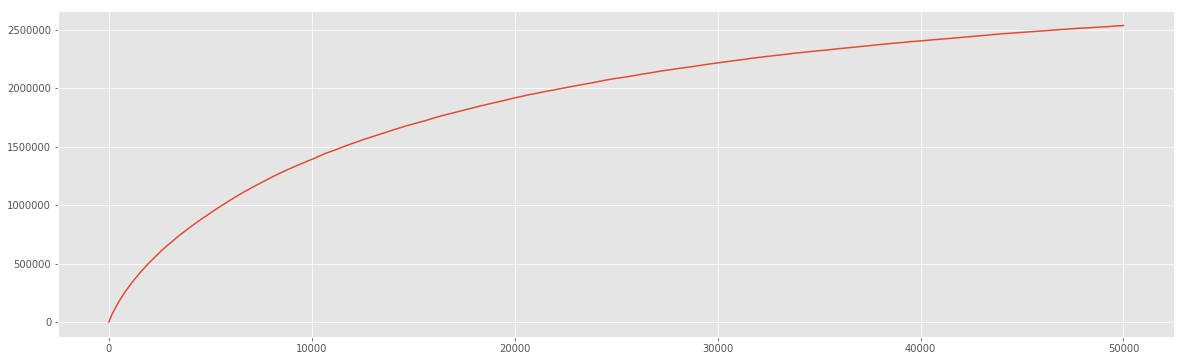

In [23]:
# plt.figure(figsize=(20, 6))
# plt.plot(episode_value_func)

In [ ]:
# get policy
policy = {}
for key, value in q_func_1.items():
    policy[key] = np.argmax(value)

In [25]:
def random_policy(possible_actions):
    return np.random.choice(possible_actions)

def trained_policy(state, possible_actions, policy, movable_piece_board_pos):
    if state in policy:
        best_action = policy[state]
        if best_action in movable_piece_board_pos.keys():
            return movable_piece_board_pos[best_action]
        
    return np.random.choice(possible_actions)

def test_mc_agent(env, num_episodes, policy):
    player1 = 0 # trained
    player2 = 1 # random
    init_q_value = 0.0
    
    episode_rewards_p1 = [0.0]
    episode_rewards_p2 = [0.0]
    time_to_win = []
    for curr_episode in range(num_episodes):
        episode_transitions_p1 = list()
        episode_transitions_p2 = list()
        dice_up = env.roll()
        state = env.reset(dice_up)
        is_done = False
        t = 0
        
        while True:
            # player 1 move
            t += 1
            
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player1, dice_up)
            reward_p1 = 0
            if len(possible_actions) != 0:
                action = trained_policy(state, possible_actions, policy, movable_piece_board_pos)
                new_state, reward_p1, done, _ = env.step(action, dice_up)
                # action['piece_id'] = (player, piece_id)
                # Therefore, use piece_id to save which piece to move in 
                # this state
                episode_transitions_p1.append((state, action['board_pos'], reward_p1))
                state = copy.deepcopy(new_state)
                
                if done:
                    break
           
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player2, dice_up)
            reward_p2 = 0
            if len(possible_actions) != 0:
                action = random_policy(possible_actions)
                new_state, reward_p2, done, _ = env.step(action, dice_up)
                episode_transitions_p2.append((state, action['board_pos'], reward_p2))
                state = copy.deepcopy(new_state)

                if done:
                    break
            
            dice_up = env.roll()
        episode_rewards_p1[-1] =+ reward_p1
        episode_rewards_p1.append(0.0)
        
        episode_rewards_p2[-1] =+ reward_p2
        episode_rewards_p2.append(0.0)
        time_to_win.append(t)
        
    return episode_rewards_p1, episode_rewards_p2, time_to_win

In [26]:
test_episode_rewards_p1, test_episode_rewards_p2, test_time_to_win = test_mc_agent(env, 1000, policy)

In [27]:
test_avg_trained = np.mean(test_episode_rewards_p1)
test_avg_random = np.mean(test_episode_rewards_p2)
print("Trained Score: ", test_avg_trained/(test_avg_random + test_avg_trained))
print("Random Score: ", test_avg_random/(test_avg_random + test_avg_trained))

Trained Score:  0.4885081942862802
Random Score:  0.5114918057137199


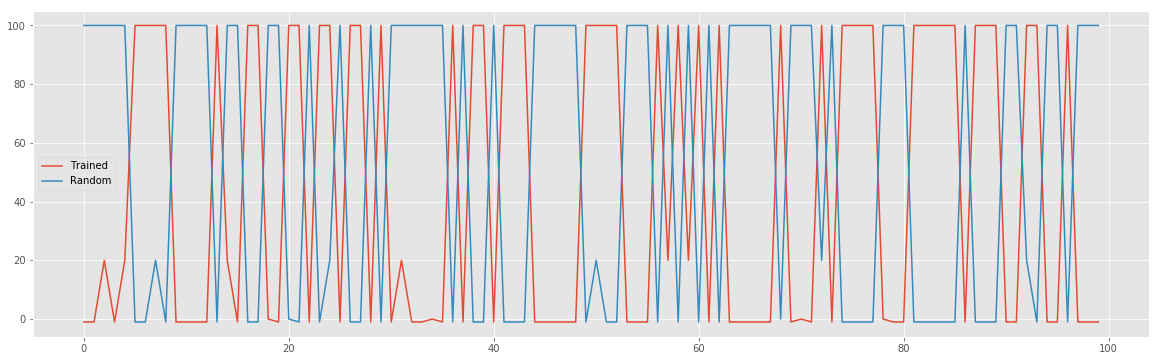

In [20]:
plt.figure(figsize=(20, 6))
trained, = plt.plot(test_episode_rewards_p1[:100], label='Trained')
random, = plt.plot(test_episode_rewards_p2[:100], label='Random')
plt.legend([trained, random], ['Trained', 'Random'])

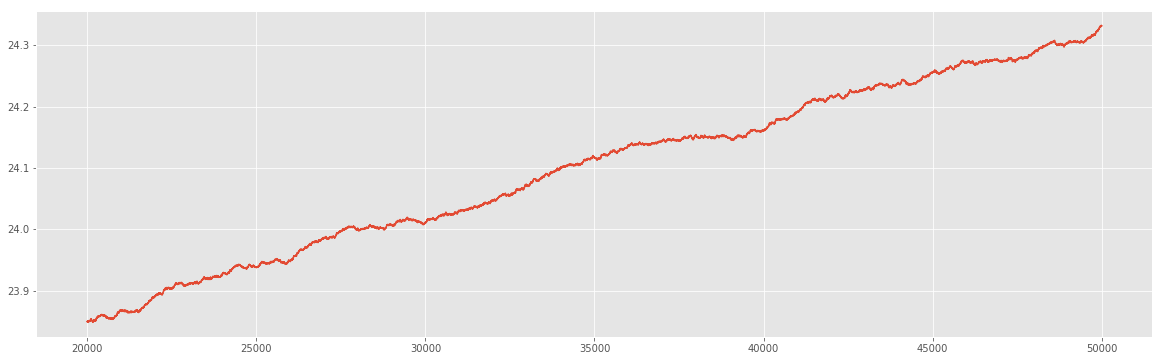

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(time_to_win).rolling(20000, min_periods=20000).mean())

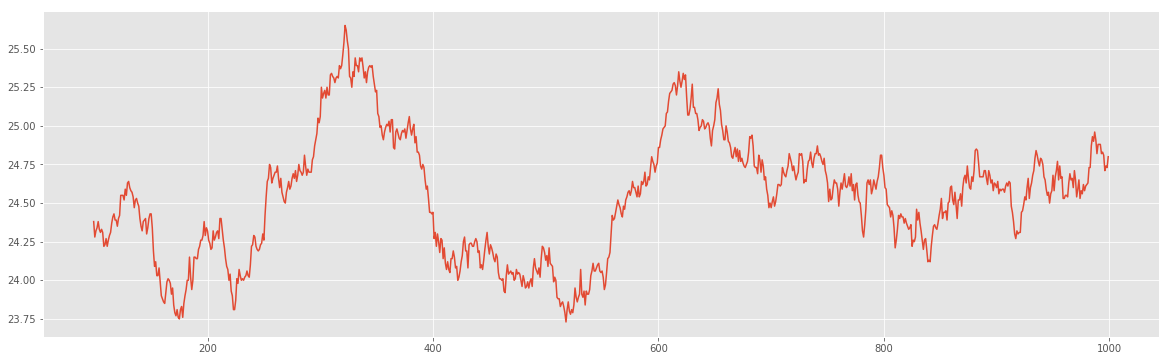

In [22]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(test_time_to_win).rolling(100, min_periods=100).mean())

In [36]:
p1_mean_rwds = np.mean(np.array(episode_rwds_p1[-1]).reshape(1, -1), axis=0)
p2_mean_rwds = np.mean(np.array(episode_rwds_p2[-1]).reshape(1, -1), axis=0)

In [22]:
# plt.figure(figsize=(20, 6))
# plt.plot(p1_mean_rwds[-100:])

In [23]:
# plt.figure(figsize=(20, 6))
# plt.plot(p2_mean_rwds[-100:])

In [24]:
# plt.figure(figsize=(20, 6))
# plt.plot(p1_mean_rwds[-100:])
# plt.plot(p2_mean_rwds[-100:])

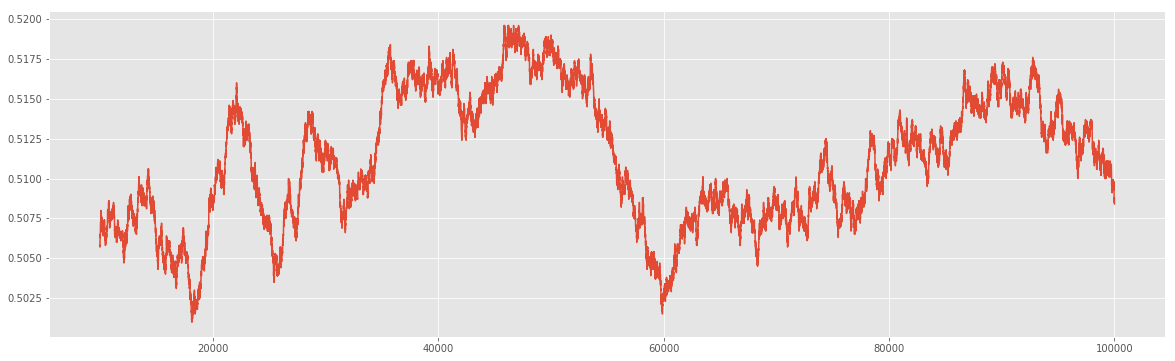

In [37]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p1_mean_rwds).rolling(10000, min_periods=10000).mean())

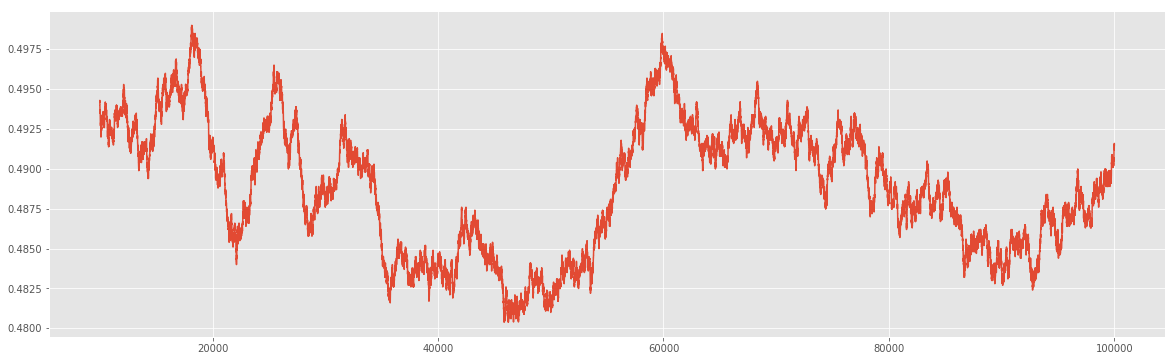

In [38]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(p2_mean_rwds).rolling(10000, min_periods=10000).mean())

In [13]:
# plt.figure(figsize=(20, 6))
# plt.plot(pd.Series(p1_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())
# plt.plot(pd.Series(p2_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())

In [16]:
policy

{((2, ()), (2, ()), 1): 21,
 ((1, (('a', 4),)), (2, ()), 1): 5,
 ((1, (('a', 4),)), (1, (('c', 4),)), 1): 21,
 ((1, (('a', 3),)), (1, (('c', 4),)), 2): 5,
 ((1, (('a', 3),)), (1, (('c', 2),)), 2): 21,
 ((1, (('a', 1),)), (1, (('c', 2),)), 1): 1,
 ((1, (('a', 1),)), (1, (('c', 1),)), 2): 17,
 ((0, (('a', 1), ('a', 3))), (1, (('c', 1),)), 1): 17,
 ((0, (('a', 1), ('a', 3))), (1, (('b', 1),)), 1): 1,
 ((0, (('a', 3), ('b', 1))), (2, ()), 2): 9,
 ((0, (('a', 3), ('b', 1))), (1, (('c', 3),)), 1): 3,
 ((0, (('a', 3), ('b', 2))), (1, (('c', 3),)), 2): 3,
 ((0, (('a', 3), ('b', 2))), (1, (('c', 1),)), 1): 17,
 ((0, (('a', 2), ('b', 2))), (1, (('c', 1),)), 2): 17,
 ((0, (('a', 2), ('b', 2))), (0, (('c', 1), ('c', 3))), 2): 17,
 ((0, (('b', 1), ('b', 2))), (0, (('c', 1), ('c', 3))), 1): 17,
 ((1, (('b', 2),)), (0, (('b', 1), ('c', 3))), 1): 9,
 ((1, (('b', 3),)), (0, (('b', 1), ('c', 3))), 2): 9,
 ((2, ()), (0, (('b', 3), ('c', 3))), 2): 19,
 ((1, (('a', 3),)), (0, (('b', 3), ('c', 3))), 2): 19,

In [14]:
q_func_1

defaultdict(<function __main__.train_mc_agent.<locals>.<lambda>>,
            {((2, ()),
              (2, ()),
              2): array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                    0., 0., 0., 0., 1., 0., 0., 0.]),
             ((1, (('a', 3),)),
              (2, ()),
              1): array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                    0., 0., 0., 0., 0., 0., 0., 0.]),
             ((1, (('a', 3),)),
              (1, (('c', 4),)),
              2): array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                    0., 0., 0., 1., 1., 0., 0., 0.]),
             ((1, (('a', 1),)),
              (1, (('c', 4),)),
              2): array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                    0., 0., 0., 0., 0., 0., 0., 0.]),
             ((1, (('a', 1),)),
              (0, (('c', 3), ('c', 4))),
              2): array([0., 1., 0., 0., 0.,